In [103]:
import pyodbc
import os
import pylab as pl
import pandas as pd
import numpy as np
import datetime
import altair as alt
alt.data_transformers.disable_max_rows()


from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
# SQL python connection to our server
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=sql-2-db;'
                      'Database=CBQ2;')
                    
cursor = conn.cursor()

In [92]:
sql_query = '''
SELECT
    ast.[ISBN]
    ,i.short_title [title]
    ,i.PRICE_AMOUNT price
    ,i.PUBLISHER_CODE publisher
    ,i.PUBLISHING_GROUP pgrp
    ,isnull(sum([CustomerOrders]),0) customer_orders
    ,isnull(sum([UnitShipped]),0) units_shipped
FROM
    [CBQ2].[cb].[Sellthrough_Amazon] ast
        inner join ebs.item i on i.ISBN = ast.ISBN
WHERE
    week < dateadd(month,3,i.AMORTIZATION_DATE)
    --AND i.isbn != '9781452173801'
    AND (i.PRICE_AMOUNT > 0 AND i.PRICE_AMOUNT IS NOT NULL)
GROUP BY
    ast.[ISBN]
    ,i.short_title
    ,i.PRICE_AMOUNT
    ,i.PUBLISHER_CODE
    ,i.PUBLISHING_GROUP
HAVING 
    isnull(sum([UnitShipped]),0)>0
'''

In [93]:
df = pd.read_sql_query(sql_query,conn)

In [94]:
print(df.shape)

df['price_n'] =  df['price'] /df['price'].abs().max()
df['units_shipped_n'] =  df['units_shipped'] /df['units_shipped'].abs().max()
df['units_shipped_log'] = np.log(df['units_shipped']) 
df.head()

(18946, 7)


,ISBN,title,price,publisher,pgrp,customer_orders,units_shipped,price_n,units_shipped_n,units_shipped_log
0,8051272890297,MS Adobe Smart Ntbk Lg Blk HC,32.95,Moleskine,MOL-PAPER,17.0,3.0,0.0659,0.000007,1.098612
1,8051272890327,MS Vol Jrnl Rul XS Powder/Royal Blu,4.95,Moleskine,MOL-PAPER,3.0,2.0,0.0099,0.000004,0.693147
2,8051272890389,MS Vol Jrnl Pln XS Sage/Seaweed Grn,4.95,Moleskine,MOL-PAPER,4.0,6.0,0.0099,0.000013,1.791759
3,8051272890402,MS Vol Jrnl Rul Pkt Powder/Royal Blu,9.95,Moleskine,MOL-PAPER,5.0,3.0,0.0199,0.000007,1.098612
4,8051272890419,"MS Volant Journal (Set of 2), PKT Ruled, Sunfl...",9.95,Moleskine,MOL-PAPER,5.0,1.0,0.0199,0.000002,0.000000


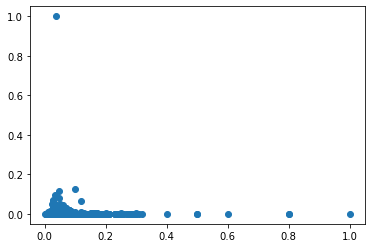

In [101]:
x = df['price_n']
Y = df['units_shipped_n']

plt.scatter(x=x,y=Y)

In [99]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['price_n','units_shipped_n']])

In [104]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]
score
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

ValueError: Expected 2D array, got 1D array instead:
array=[6.60878837e-06 4.40585891e-06 1.32175767e-05 ... 2.48931028e-04
 2.42322240e-05 3.76700937e-04].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.